<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/machine_learning_for_disk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## disk 예측 (disk I/O와 사용률 중에서 사용률이 더 HPC 종량제에 연결 쉬움)
### 디스크 사용률은 onTune에서 한달치만 저장 가능
### 한 달 평균치를 모아서 1년 치 생성
### 업무시간 피해서 백업과 같은 배치 주기적으로 발생하도록 주기 spike 만들기
### 야간 작업 중 일부 시스템 로그, 캐시도 야간 작업 (18시~7시) 중 함께 저장 -> disk 사용량 계단식 증가


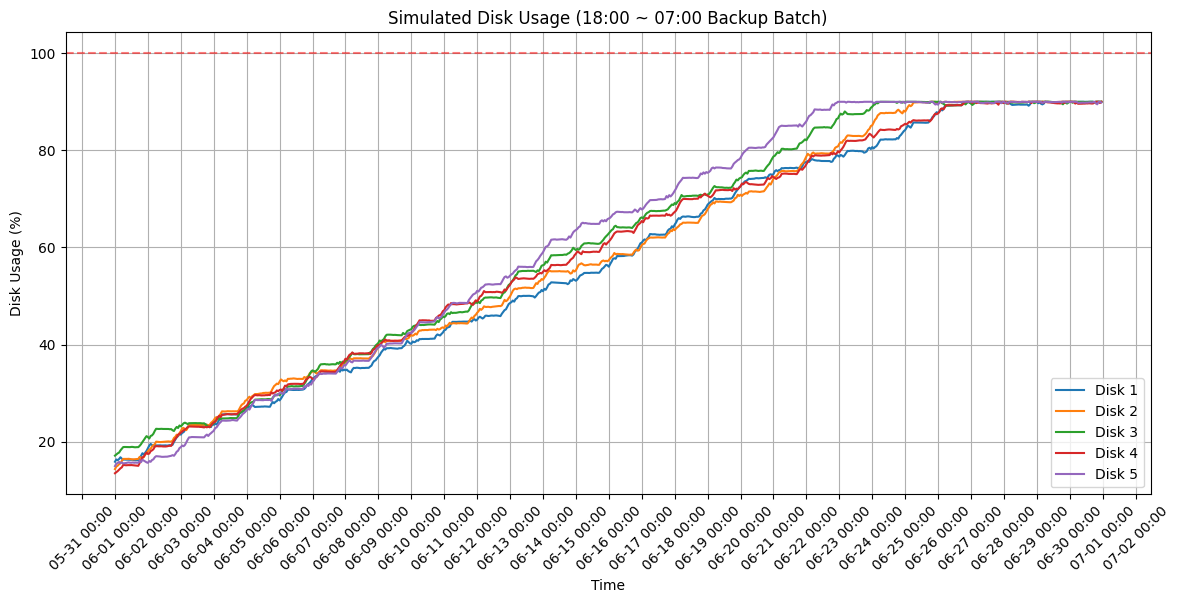

In [ ]:
# 한달 동안의 디스크 사용량

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# 시뮬레이션 설정
days = 30
hours_per_day = 24
total_steps = days * hours_per_day

# 시작 날짜 설정
start_time = datetime(2025, 6, 1, 0, 0)
time_datetimes = [start_time + timedelta(hours=i) for i in range(total_steps)]

n_disks = 5
disk_usage = np.zeros((n_disks, total_steps))
initial_usage = np.random.uniform(10, 20, size=n_disks)

backup_hours = list(range(18, 24)) + list(range(0, 7))

for d in range(n_disks):
    usage = initial_usage[d]
    for t in range(total_steps):
        current_hour = t % 24
        if current_hour in backup_hours:
            if np.random.rand() < 0.8:
                usage += np.random.uniform(0.08, 0.6)
            else:
                usage -= np.random.uniform(0.1, 0.3)
        else:
            usage += np.random.normal(0, 0.03)
        usage = min(usage, 90)
        disk_usage[d, t] = usage

# 시각화
plt.figure(figsize=(14, 6))
for d in range(n_disks):
    plt.plot(time_datetimes, disk_usage[d], label=f'Disk {d+1}')

plt.xlabel("Time")
plt.ylabel("Disk Usage (%)")
plt.title("Simulated Disk Usage (18:00 ~ 07:00 Backup Batch)")

# ✅ x축 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # 2일 간격
plt.xticks(rotation=45)

plt.axhline(100, color='red', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True)

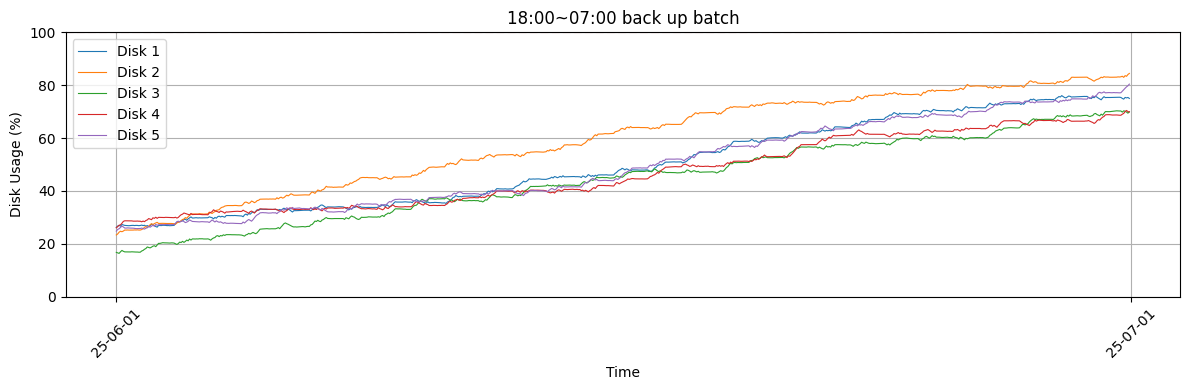

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# 시뮬레이션 설정
months = 1
days_per_month = 30
hours_per_day = 24
steps_per_month = days_per_month * hours_per_day  # 720시간
total_steps = months * steps_per_month  # 8640시간

n_disks = 5
disk_usage_year = np.zeros((n_disks, total_steps))
time_datetimes_year = []

start_time = datetime(2025, 6, 1, 0, 0)
backup_hours = list(range(18, 24)) + list(range(0, 7))

for d in range(n_disks):
    usage = np.random.uniform(10, 20)  # 초기 사용량 (0~90 기준)
    for m in range(months):
        month_scale = (m + 1) / months  # 점점 증가 (1/12 ~ 12/12)
        for t in range(steps_per_month):
            current_hour = t % 24
            if current_hour in backup_hours:
                if np.random.rand() < 0.6:
                    usage += np.random.uniform(0.08, 0.5) * month_scale
                else:
                    usage -= np.random.uniform(0.1, 0.3)
            else:
                usage += np.random.normal(0, 0.03) * month_scale
            usage = np.clip(usage, 0, 80)  # 최대제한
            global_idx = m * steps_per_month + t
            disk_usage_year[d, global_idx] = usage
            if d == 0:
                time_datetimes_year.append(start_time + timedelta(hours=global_idx))

# % 변환
disk_usage = (disk_usage_year / 70) * 100

# 시각화
plt.figure(figsize=(12, 4))
for d in range(n_disks):
    plt.plot(time_datetimes_year, disk_usage[d], label=f'Disk {d+1}', linewidth=0.8)

plt.xlabel("Time")
plt.ylabel("Disk Usage (%)")
plt.title("18:00~07:00 back up batch")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.axhline(100, color='red', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
# disk data 생성
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense


# 시뮬레이션 (5개 디스크 개별)
months = 1
days_per_month = 30
hours_per_day = 24
steps_per_month = days_per_month * hours_per_day
total_steps = months * steps_per_month

n_disks = 5
disk_usage_year = np.zeros((n_disks, total_steps))
time_datetimes_year = []

start_time = pd.Timestamp('2025-06-01 00:00:00')
backup_hours = list(range(18, 24)) + list(range(0, 7))

for d in range(n_disks):
    usage = np.random.uniform(10, 20)
    for m in range(months):
        month_scale = (m + 1) / months
        for t in range(steps_per_month):
            current_hour = t % 24
            if current_hour in backup_hours:
                if np.random.rand() < 0.6:
                    usage += np.random.uniform(0.08, 0.5) * month_scale
                else:
                    usage -= np.random.uniform(0.1, 0.3)
            else:
                usage += np.random.normal(0, 0.03) * month_scale
            usage = np.clip(usage, 0, 80)
            global_idx = m * steps_per_month + t
            disk_usage_year[d, global_idx] = usage
            if d == 0:
                time_datetimes_year.append(start_time + pd.Timedelta(hours=global_idx))

disk_usage_percent = (disk_usage_year / 90) * 100
time_index = pd.DatetimeIndex(time_datetimes_year)
df_disks = pd.DataFrame(disk_usage_percent.T, columns=[f'Disk{i+1}' for i in range(n_disks)], index=time_index)

# df_disks_resample = df_disks # resample 없는 경우
# resampling
df_disks_resample = df_disks.resample('30T').interpolate('linear')

# 시퀀스 생성 함수
def create_sequences(data, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i+past_steps])
        y.append(data[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)


/tmp/ipython-input-38-1707394311.py:50: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_disks_resample = df_disks.resample('30T').interpolate('linear')


## 1. CNN-LSTM 적용 + sliding window(5)
### 각각의 디스크가 영향없이 독립적으로 -> 각각 학습 시켜야해


In [ ]:
# 디스크별 개별 학습
past_steps = 20
future_steps = 5
split_ratio = 0.8

disk_preds = []
disk_trues = []
disk_time_indexes = []

for d in range(n_disks):
    usage = df_disks_resample.iloc[:, d].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(usage)

    X, y = create_sequences(scaled, past_steps, future_steps)
    y_first = y[:, 0]  # 첫 step만 예측

    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y_first[:train_size], y_first[train_size:]

    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

    pred = model.predict(X_test)
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    disk_preds.append(pred_inv.flatten())
    disk_trues.append(true_inv.flatten())

    time_idx = df_disks_resample.index[past_steps + train_size : past_steps + train_size + len(pred)]
    disk_time_indexes.append(time_idx)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


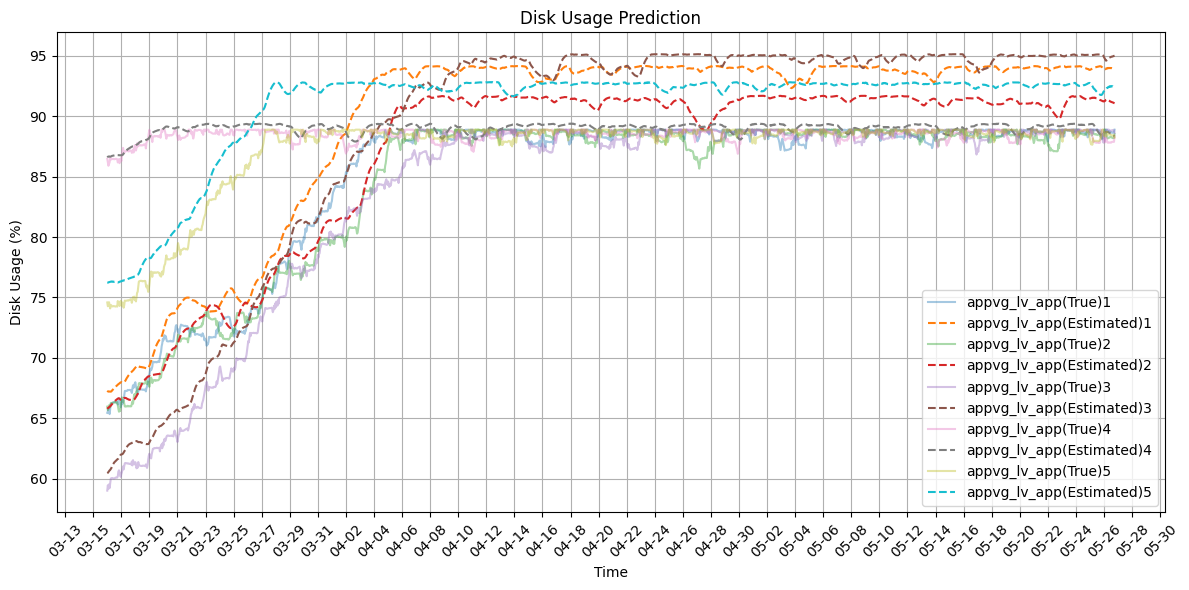

In [10]:
plt.figure(figsize=(12, 6))
for d in range(n_disks):
    plt.plot(disk_time_indexes[d], disk_trues[d], label=f'appvg_lv_app(True){d+1}', alpha=0.4)
    plt.plot(disk_time_indexes[d], disk_preds[d], label=f'appvg_lv_app(Estimated){d+1}', linestyle='--')
plt.title("Disk Usage Prediction")
plt.xlabel("Time")
plt.ylabel("Disk Usage (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



 Disk1 Usage Prediction Summary
 Moving Average
  MAE : 0.3266
  RMSE: 0.4655
CNN-LSTM
  MAE : 4.5181
  RMSE: 4.7166


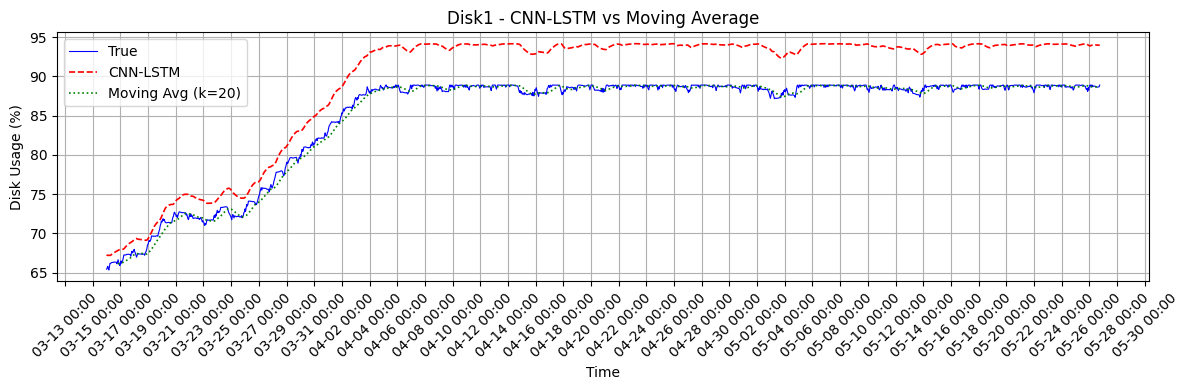


 Disk2 Usage Prediction Summary
 Moving Average
  MAE : 0.3584
  RMSE: 0.5109
CNN-LSTM
  MAE : 2.2439
  RMSE: 2.4390


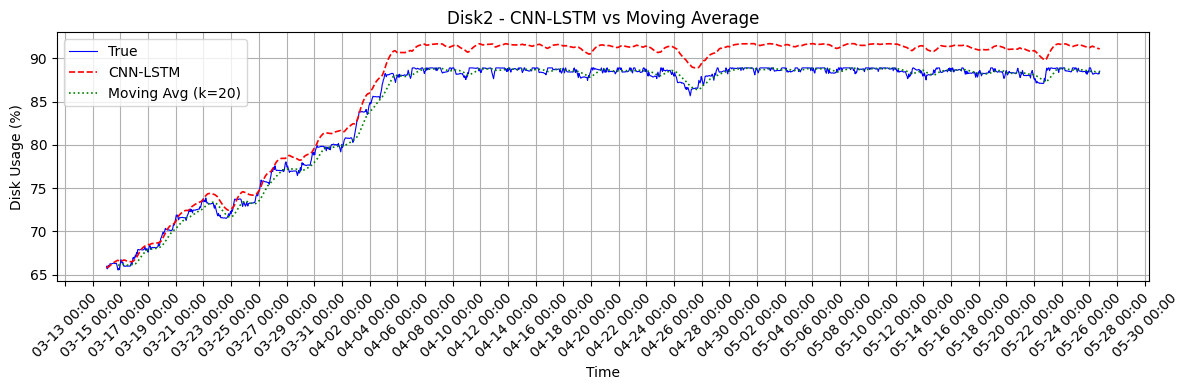


 Disk3 Usage Prediction Summary
 Moving Average
  MAE : 0.3465
  RMSE: 0.4874
CNN-LSTM
  MAE : 5.1952
  RMSE: 5.4602


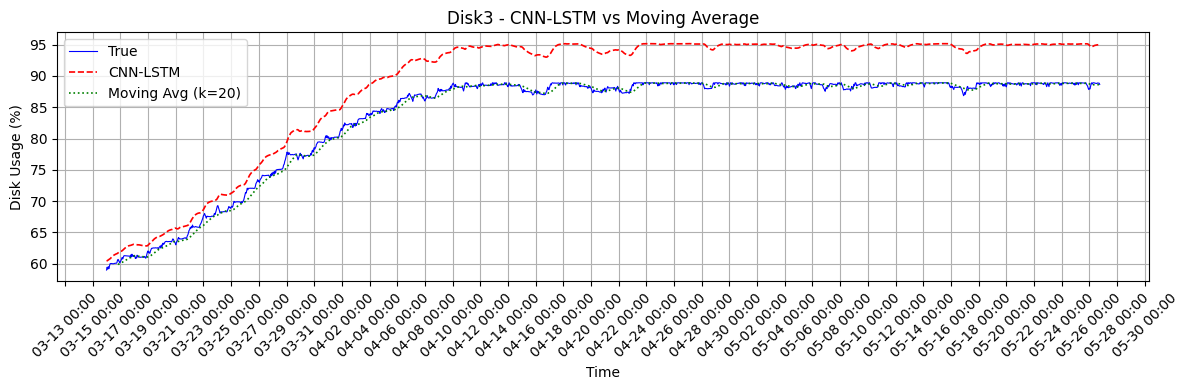


 Disk4 Usage Prediction Summary
 Moving Average
  MAE : 0.2409
  RMSE: 0.3240
CNN-LSTM
  MAE : 0.5389
  RMSE: 0.6033


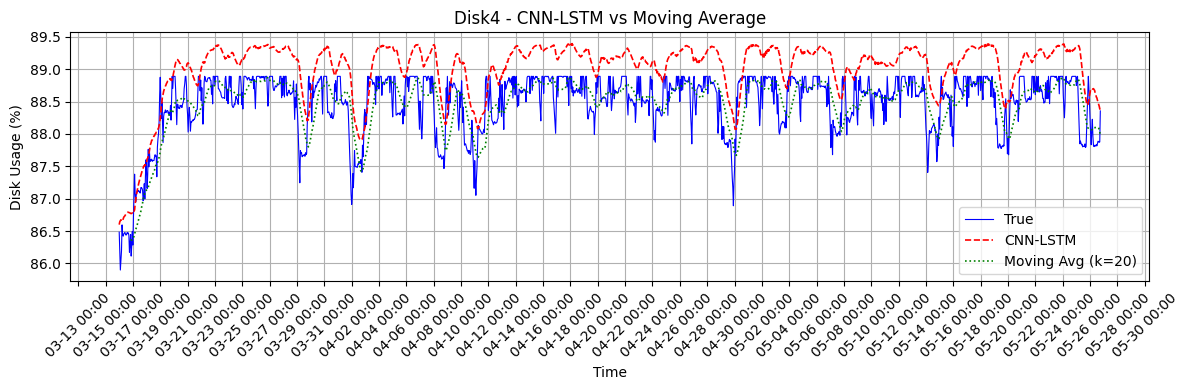


 Disk5 Usage Prediction Summary
 Moving Average
  MAE : 0.2607
  RMSE: 0.3782
CNN-LSTM
  MAE : 3.6664
  RMSE: 3.7381


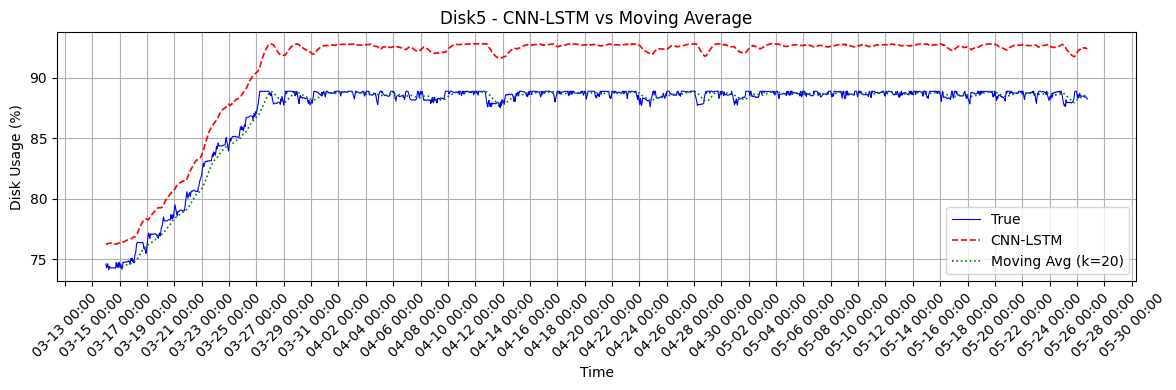

In [18]:
# CNN-LSTM 결과 시각화, MV와 비교
from sklearn.metrics import mean_absolute_error, mean_squared_error

future_steps = 5
future_interval = 5
k = 20  # moving average window

for d in range(n_disks):
    print(f"\n Disk{d+1} Usage Prediction Summary")

    # 예측 결과
    pred = disk_preds[d]
    true = disk_trues[d]
    time_idx = disk_time_indexes[d]

    # CNN-LSTM 예측 정렬
    all_future_times, all_future_preds = [], []
    for i in range(len(pred)):
        for j in range(future_steps):
            future_time = time_idx[i] + pd.Timedelta(minutes=(j+1)*future_interval)
            all_future_times.append(future_time)
            all_future_preds.append(pred[i])

    pred_df = pd.DataFrame({
        "time": all_future_times,
        "pred": np.array(all_future_preds).flatten()
    })
    pred_df_mean = pred_df.groupby("time").mean().sort_index()

    # test true
    test_series_true = pd.Series(true, index=time_idx[:len(true)])
    test_series_pred = pred_df_mean['pred'].reindex(test_series_true.index, method="nearest")

    # moving average
    moving_avg_pred = [
        np.mean(test_series_true.iloc[i-k:i])
        for i in range(k, len(test_series_true))
    ]
    moving_avg_pred_series = pd.Series(moving_avg_pred, index=test_series_true.index[k:])

    # 정확도
    mae_cnn  = mean_absolute_error(test_series_true.values, test_series_pred.values)
    rmse_cnn = np.sqrt(mean_squared_error(test_series_true.values, test_series_pred.values))

    true_vals_ma = test_series_true.values[k:]
    mae_ma  = mean_absolute_error(true_vals_ma, moving_avg_pred)
    rmse_ma = np.sqrt(mean_squared_error(true_vals_ma, moving_avg_pred))

    print(" Moving Average")
    print(f"  MAE : {mae_ma:.4f}")
    print(f"  RMSE: {rmse_ma:.4f}")

    print("CNN-LSTM")
    print(f"  MAE : {mae_cnn:.4f}")
    print(f"  RMSE: {rmse_cnn:.4f}")

    plt.figure(figsize=(12, 4))
    plt.plot(test_series_true.index, test_series_true.values, label="True", color="blue", linewidth=0.8)
    plt.plot(test_series_pred.index, test_series_pred.values, label="CNN-LSTM", color="red", linestyle="--", linewidth=1.2)
    plt.plot(moving_avg_pred_series.index, moving_avg_pred_series.values, label=f"Moving Avg (k={k})", color='green', linestyle=':', linewidth=1.2)

    plt.title(f"Disk{d+1} - CNN-LSTM vs Moving Average")
    plt.xlabel("Time")
    plt.ylabel("Disk Usage (%)")
    plt.legend()
    plt.grid(True)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
    plt.close()


## FLNN + GA-PSO

In [16]:
!pip install numpy deap pyswarms


===== Disk1 - FLNN GA+PSO + Moving Average =====
GA MAE: 0.03409661059920781
PSO MAE : 0.009318854566527288
Moving Average
 MAE : 0.4874
 RMSE: 0.6496
FLNN+GA-PSO
 MAE : 0.3925
 RMSE: 0.5234


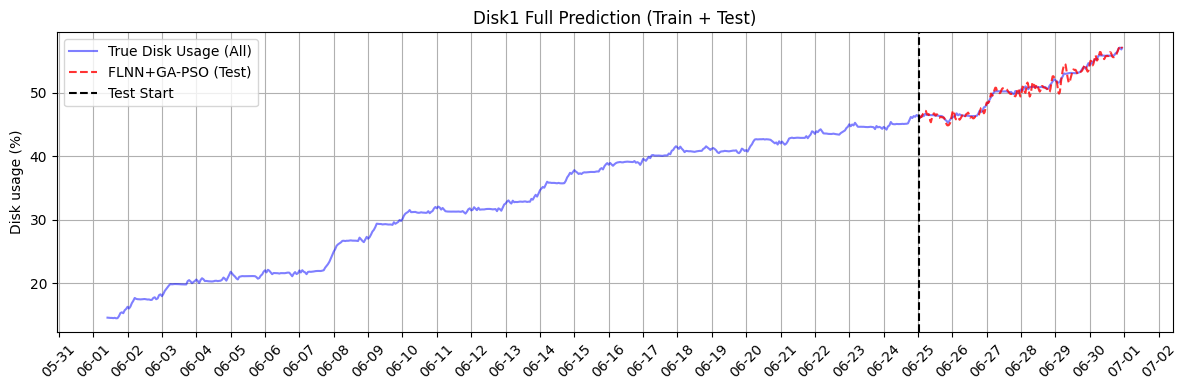

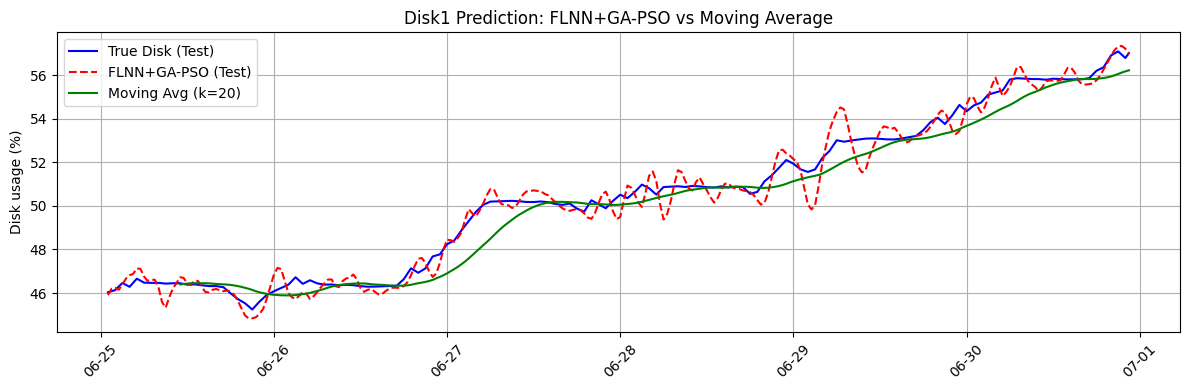


===== Disk2 - FLNN GA+PSO + Moving Average =====
GA MAE: 0.046770303864227154
PSO MAE : 0.007661853573352005
Moving Average
 MAE : 0.3340
 RMSE: 0.4344
FLNN+GA-PSO
 MAE : 0.3688
 RMSE: 0.4783


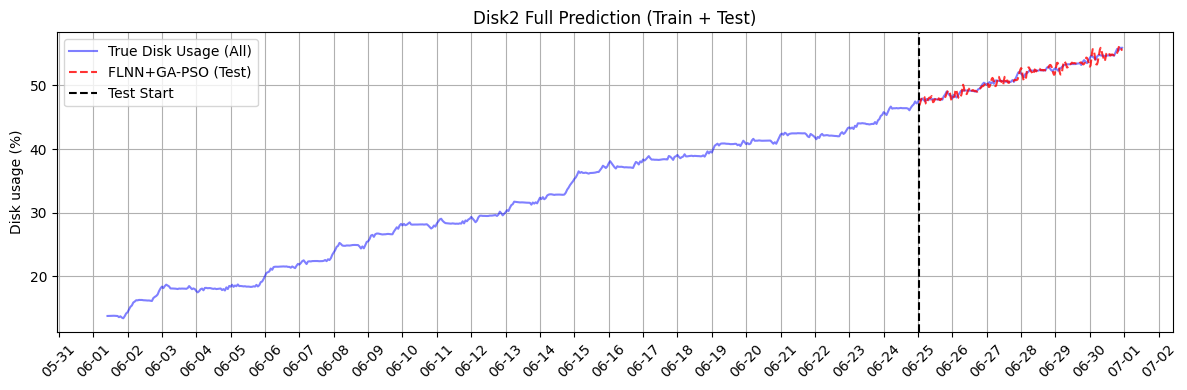

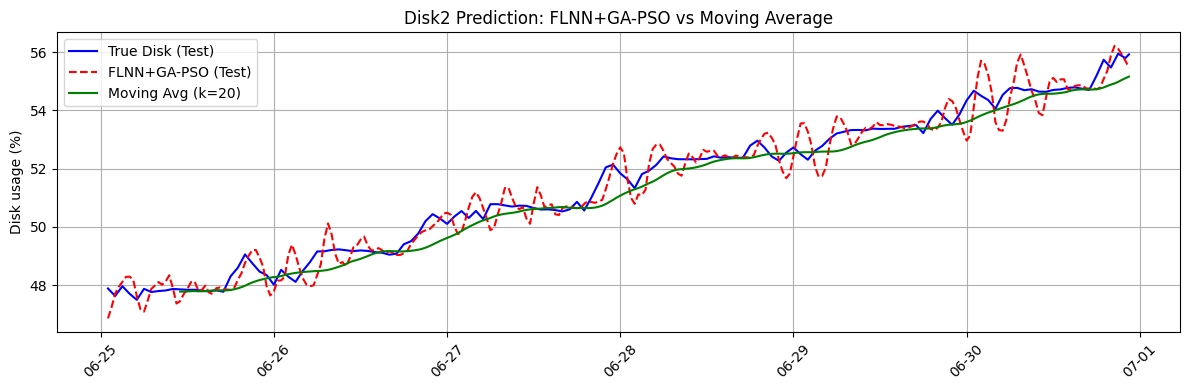


===== Disk3 - FLNN GA+PSO + Moving Average =====
GA MAE: 0.016372535338674003
PSO MAE : 0.011390708264352872
Moving Average
 MAE : 0.3667
 RMSE: 0.4941
FLNN+GA-PSO
 MAE : 0.3793
 RMSE: 0.4898


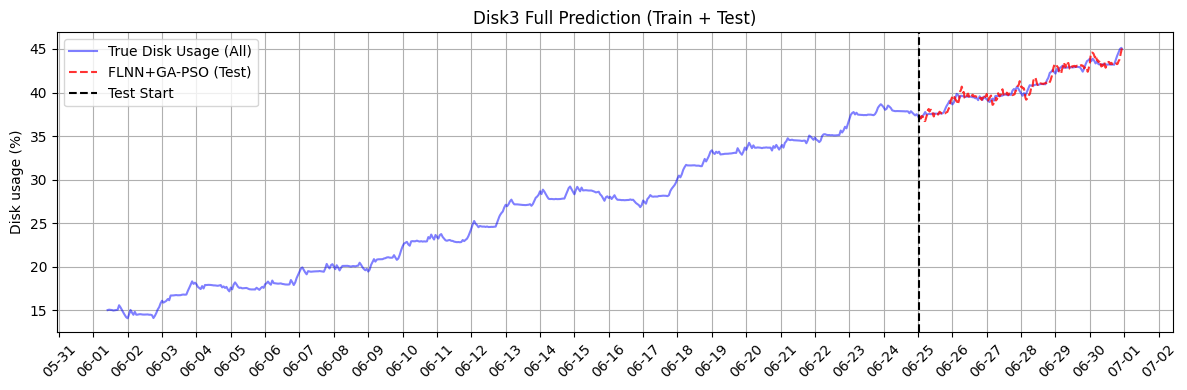

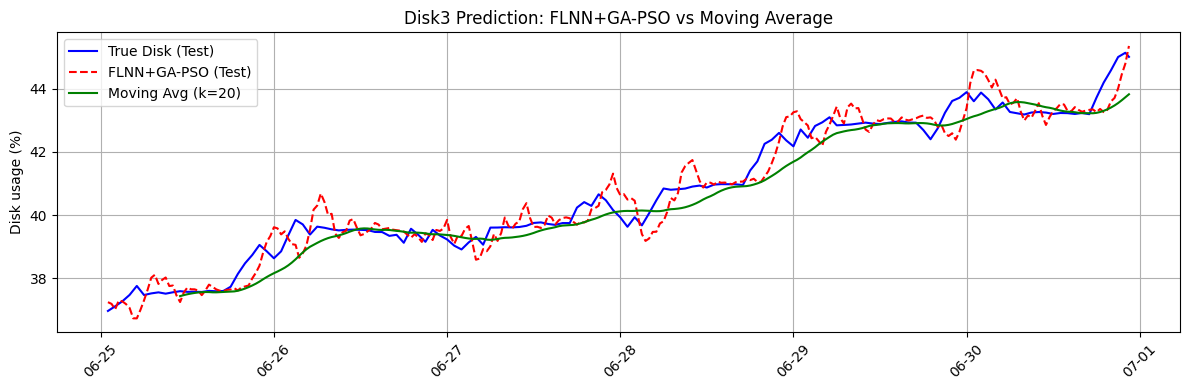


===== Disk4 - FLNN GA+PSO + Moving Average =====
GA MAE: 0.19053176002966726
PSO MAE : 0.01428997255483627
Moving Average
 MAE : 0.4830
 RMSE: 0.6699
FLNN+GA-PSO
 MAE : 0.4299
 RMSE: 0.5543


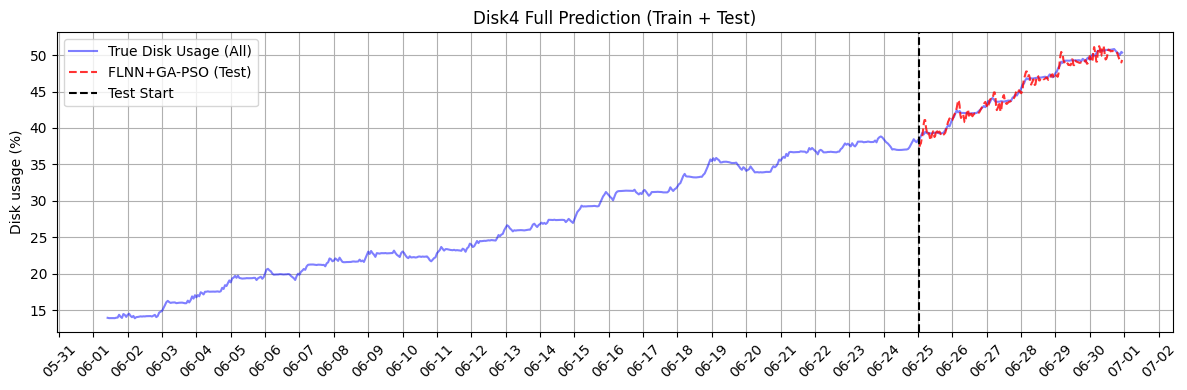

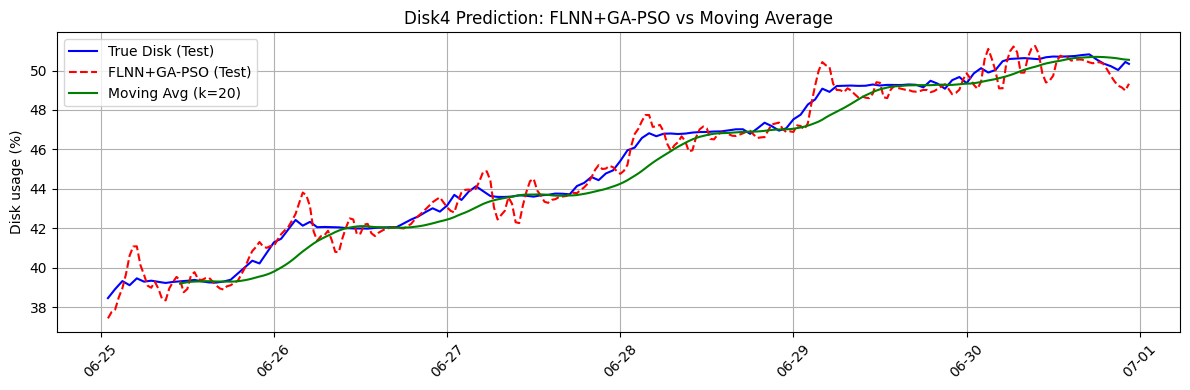


===== Disk5 - FLNN GA+PSO + Moving Average =====
GA MAE: 0.11785975118238626
PSO MAE : 0.009425530615318787
Moving Average
 MAE : 0.4194
 RMSE: 0.6045
FLNN+GA-PSO
 MAE : 0.3836
 RMSE: 0.5493


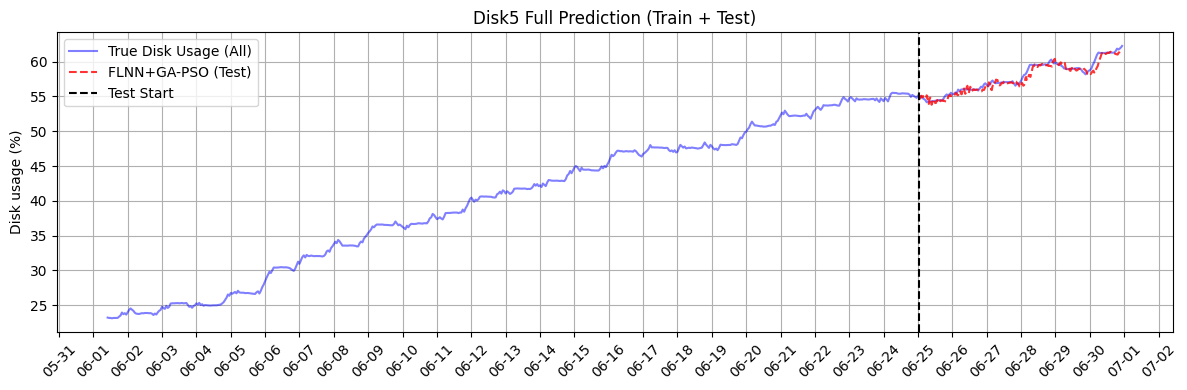

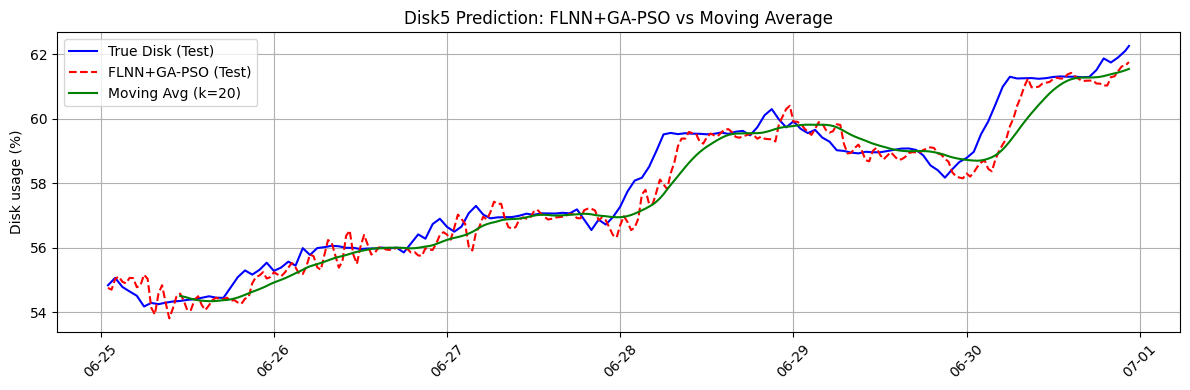

In [42]:
# FLNN결과 시각화, MV함꼐 표시, testdata와 함께 표시 (% 단위로 출력)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from deap import base, creator, tools, algorithms
import pyswarms as ps
import pandas as pd
import matplotlib.dates as mdates

past_steps = 20
future_steps = 1
pop_size = 20
num_generations = 10
num_particles = 20
pso_iters = 100
k = 20  # moving average window

# 전체 디스크
for d in range(n_disks):
    print(f"\n===== Disk{d+1} - FLNN GA+PSO + Moving Average =====")

    usage = df_disks_resample.iloc[:, d].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_usage = scaler.fit_transform(usage).flatten()

    X, y = [], []
    for i in range(len(scaled_usage) - past_steps - future_steps):
        X.append(scaled_usage[i:i+past_steps])
        y.append(scaled_usage[i+past_steps:i+past_steps+future_steps])
    X = np.array(X)
    y = np.array(y).flatten()

    input_dim = past_steps

    if "FitnessMin" in creator.__dict__:
        del creator.FitnessMin
    if "Individual" in creator.__dict__:
        del creator.Individual

    # FLNN
    def flnn_predict(weights, X):
        bias = weights[-1]
        return np.dot(X, weights[:-1]) + bias

    def eval_mae(individual):
        weights = np.array(individual)
        if weights.shape[0] != input_dim + 1:
            return (float("inf"),)
        y_pred = flnn_predict(weights, X)
        return (np.abs(y - y_pred).mean(),)

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -1, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=input_dim+1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", eval_mae)

    pop = toolbox.population(n=pop_size)
    pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)
    best_ga = tools.selBest(pop, 1)[0]
    print("GA MAE:", eval_mae(best_ga)[0])

    def pso_objective(w):
        losses = []
        for particle in w:
            y_pred = flnn_predict(particle, X)
            losses.append(np.abs(y - y_pred).mean())
        return np.array(losses)

    x_init = np.tile(best_ga, (num_particles, 1)) + np.random.normal(0, 0.1, (num_particles, input_dim+1))
    options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
    optimizer = ps.single.GlobalBestPSO(
        n_particles=num_particles,
        dimensions=input_dim + 1,
        options=options,
        init_pos=x_init
    )

    best_cost, best_pso = optimizer.optimize(pso_objective, iters=pso_iters, verbose=False)
    print("PSO MAE :", best_cost)

    y_pred = flnn_predict(best_pso, X)

    y = scaler.inverse_transform(y.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    split_ratio = 0.8
    split_idx = int(len(y) * split_ratio)
    train_true = y[:split_idx]
    test_true = y[split_idx:]
    train_pred = y_pred[:split_idx]
    test_pred = y_pred[split_idx:]

    time_index_all = df_disks_resample.index[past_steps : past_steps + len(y)]
    train_time_index = time_index_all[:split_idx]
    test_time_index = time_index_all[split_idx:]

    # Moving Average
    ma_pred = [np.mean(test_true[i-k:i]) for i in range(k, len(test_true))]
    ma_true_vals = test_true[k:]

    mae_ma  = mean_absolute_error(ma_true_vals, ma_pred)
    rmse_ma = np.sqrt(mean_squared_error(ma_true_vals, ma_pred))
    print("Moving Average")
    print(f" MAE : {mae_ma:.4f}")
    print(f" RMSE: {rmse_ma:.4f}")

    aligned_test_pred = test_pred[k:]
    aligned_test_true = test_true[k:]
    mae_flnn = mean_absolute_error(aligned_test_true, aligned_test_pred)
    rmse_flnn = np.sqrt(mean_squared_error(aligned_test_true, aligned_test_pred))
    print("FLNN+GA-PSO")
    print(f" MAE : {mae_flnn:.4f}")
    print(f" RMSE: {rmse_flnn:.4f}")

    plt.figure(figsize=(12, 4))
    plt.plot(time_index_all, y, label="True Disk Usage (All)", color="blue", alpha=0.5)
    plt.plot(test_time_index, test_pred, label="FLNN+GA-PSO (Test)", color="red", linestyle="--", alpha=0.8)
    plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.xticks(rotation=45)

    plt.ylabel("Disk usage (%)")
    plt.title(f"Disk{d+1} Full Prediction (Train + Test)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(test_time_index, test_true, label="True Disk (Test)", color="blue")
    plt.plot(test_time_index, test_pred, label="FLNN+GA-PSO (Test)", color="red", linestyle="--")
    plt.plot(test_time_index[k:], ma_pred, label=f"Moving Avg (k={k})", color="green", linewidth=1.5)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45)

    plt.ylabel("Disk usage (%)")
    plt.title(f"Disk{d+1} Prediction: FLNN+GA-PSO vs Moving Average")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## **[DISK] **기간 및 모델 별 결과 비교 그래프 (Mov_avg, CNN_LSTM, FLNN) (30,90,180,270,360일)

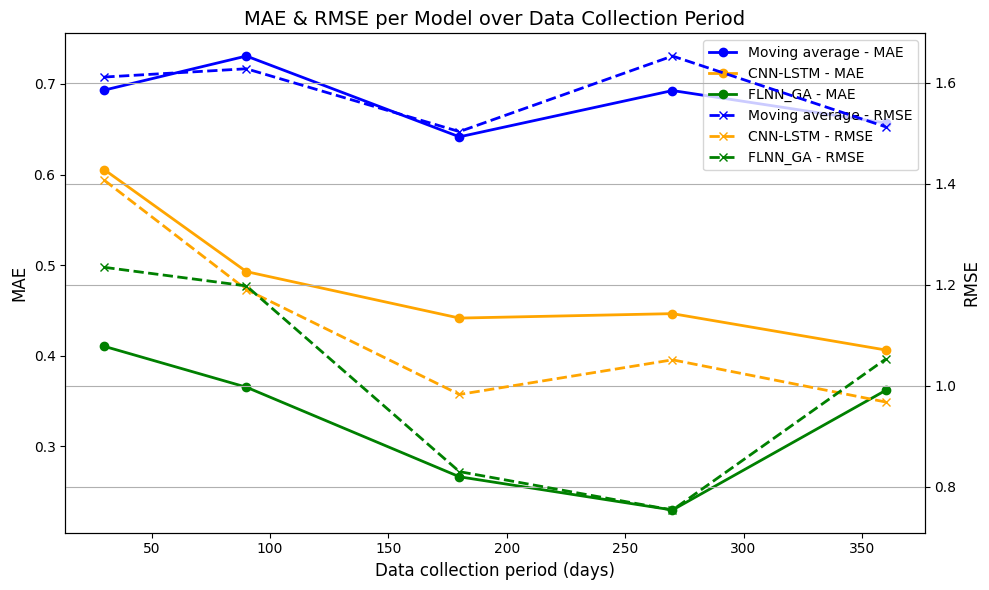

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# dataset
periods = [30, 90, 180, 270, 360]

mae_data = {
    'Moving average': [0.6932, 0.7308, 0.6416, 0.6927, 0.6569],
    'CNN-LSTM': [0.6053, 0.4928, 0.4415, 0.4464, 0.4063],
    'FLNN_GA': [0.4103, 0.3652, 0.2663, 0.2296, 0.3616]
}

rmse_data = {
    'Moving average': [1.6116, 1.6280, 1.5035, 1.6532, 1.5131],
    'CNN-LSTM': [1.4071, 1.1906, 0.9829, 1.0515, 0.9680],
    'FLNN_GA': [1.2347, 1.1979, 0.8300, 0.7540, 1.0528]
}

# color
colors = {
    'Moving average': 'blue',
    'CNN-LSTM': 'orange',
    'FLNN_GA': 'green'
}

fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()  # right y axis

for model in mae_data:
    ax1.plot(periods, mae_data[model], marker='o', label=f'{model} - MAE', color=colors[model], linewidth=2)
    ax2.plot(periods, rmse_data[model], marker='x', linestyle='--', label=f'{model} - RMSE', color=colors[model], linewidth=2)

# axis
ax1.set_xlabel("Data collection period (days)", fontsize=12)
ax1.set_ylabel("MAE", color='black', fontsize=12)
ax2.set_ylabel("RMSE", color='black', fontsize=12)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=10)

plt.title("MAE & RMSE per Model over Data Collection Period", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
